<a href="https://colab.research.google.com/github/enockmwizerwa123/Data-forecasting-using-Python/blob/main/AirQuality_Prediction_LSTM_Group_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep learning: Time Series forecasting
**Author:** [Dr. Habiboulaye Amadou-Boubacar](https://www.linkedin.com/in/habiboulaye-amadou-boubacar-8b153710)

This notebook takes inspiration from works of Jason Brownlee

## Tutorial on Deep learning: Time Series forecasting
### Recurent Neural Networks: Develop an LSTM (Long Short-Term Memory)
* Air Pollution data
* Baseline model
* Vanilla LSTM model
* LSTM with scaled data
* StackedLSTM
* LTSM-CNN (optional)


### Populating namespace

In [1]:
import pandas as pd
from matplotlib import pylab as plt
import matplotlib.pyplot  as pl
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from google.colab import files

### Air Pollution dataset ([Beijing PM2.5 Data Set](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv))
The dataset is collected from the US embassy in Beijing, China. It reports the Air quality and the weather each hour for five(5) years.
The data including the pollutant (PM2.5 concentration) to forecast is described with varibles listed below:
* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* pm2.5: PM2.5 concentration
* DEWP: Dew Point
* TEMP: Temperature
* PRES: Pressure
* cbwd: Combined wind direction
* Iws: Cumulated wind speed
* Is: Cumulated hours of snow
* Ir: Cumulated hours of rain

The Goal is to forecast the pollution at the next hour given history of pollution and weather condition



#### Download [Beijing PM2.5 Data Set](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv)

In [2]:
!rm pollution.csv
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
!ls

rm: cannot remove 'pollution.csv': No such file or directory
--2023-09-23 11:30:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘pollution.csv’

pollution.csv       100%[===================>]   1.92M  --.-KB/s    in 0.009s  

2023-09-23 11:30:58 (211 MB/s) - ‘pollution.csv’ saved [2010492/2010492]

pollution.csv  sample_data


<font color='red'>
<b>EXERCICES</b>: Replace the <b>FILL_IN</b> pattern with the correct codes then execute the cell
 </font>

In [7]:
data = pd.read_csv('pollution.csv')
print(data.shape)
# Display the first (5) rows of the dataframe
data.head()


(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [4]:
# Check NAs (missing values) for all the columns
data.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [ ]:
#Check variable cbwd value occurences using value_counts
data['cbwd'].groupby(data['cbwd']).count()

cbwd
NE     4997
NW    14150
SE    15290
cv     9387
Name: cbwd, dtype: int64

In [9]:
#data.cbwd.value_counts()

#### Reload, preprocess and visualize data


In [10]:
# Load & format date
data = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=lambda d: datetime.strptime(d, '%Y %m %d %H'))
# Drop No(variable) column
# dt=data.iloc[:,1:]
data=data.drop(columns=["No"])
# Fill all the NA with value  0
data['pm2.5']=data['pm2.5'].fillna(0)
# dt.replace(np.nan,0)
# label encodeing of cbwd (wind direction feature): categories to numerics
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data["cbwd"] = label_encoder.fit_transform(data[["cbwd"]])
# Encode labels in column 'species'.

# use the fit__transform function to encode the data
# rename columns
data.rename(columns = {"pm2.5":"pollution","cbwd":"WINDdir","Iws":"WINDsped",	"Is":"SNOW",	"Ir":"RAIN"}, inplace=True)
data.index.name = 'datetime'
# data.head()
np.unique(data.WINDdir)
# ['NE', 'NW', 'SE', 'cv']=[0, 1, 2, 3]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

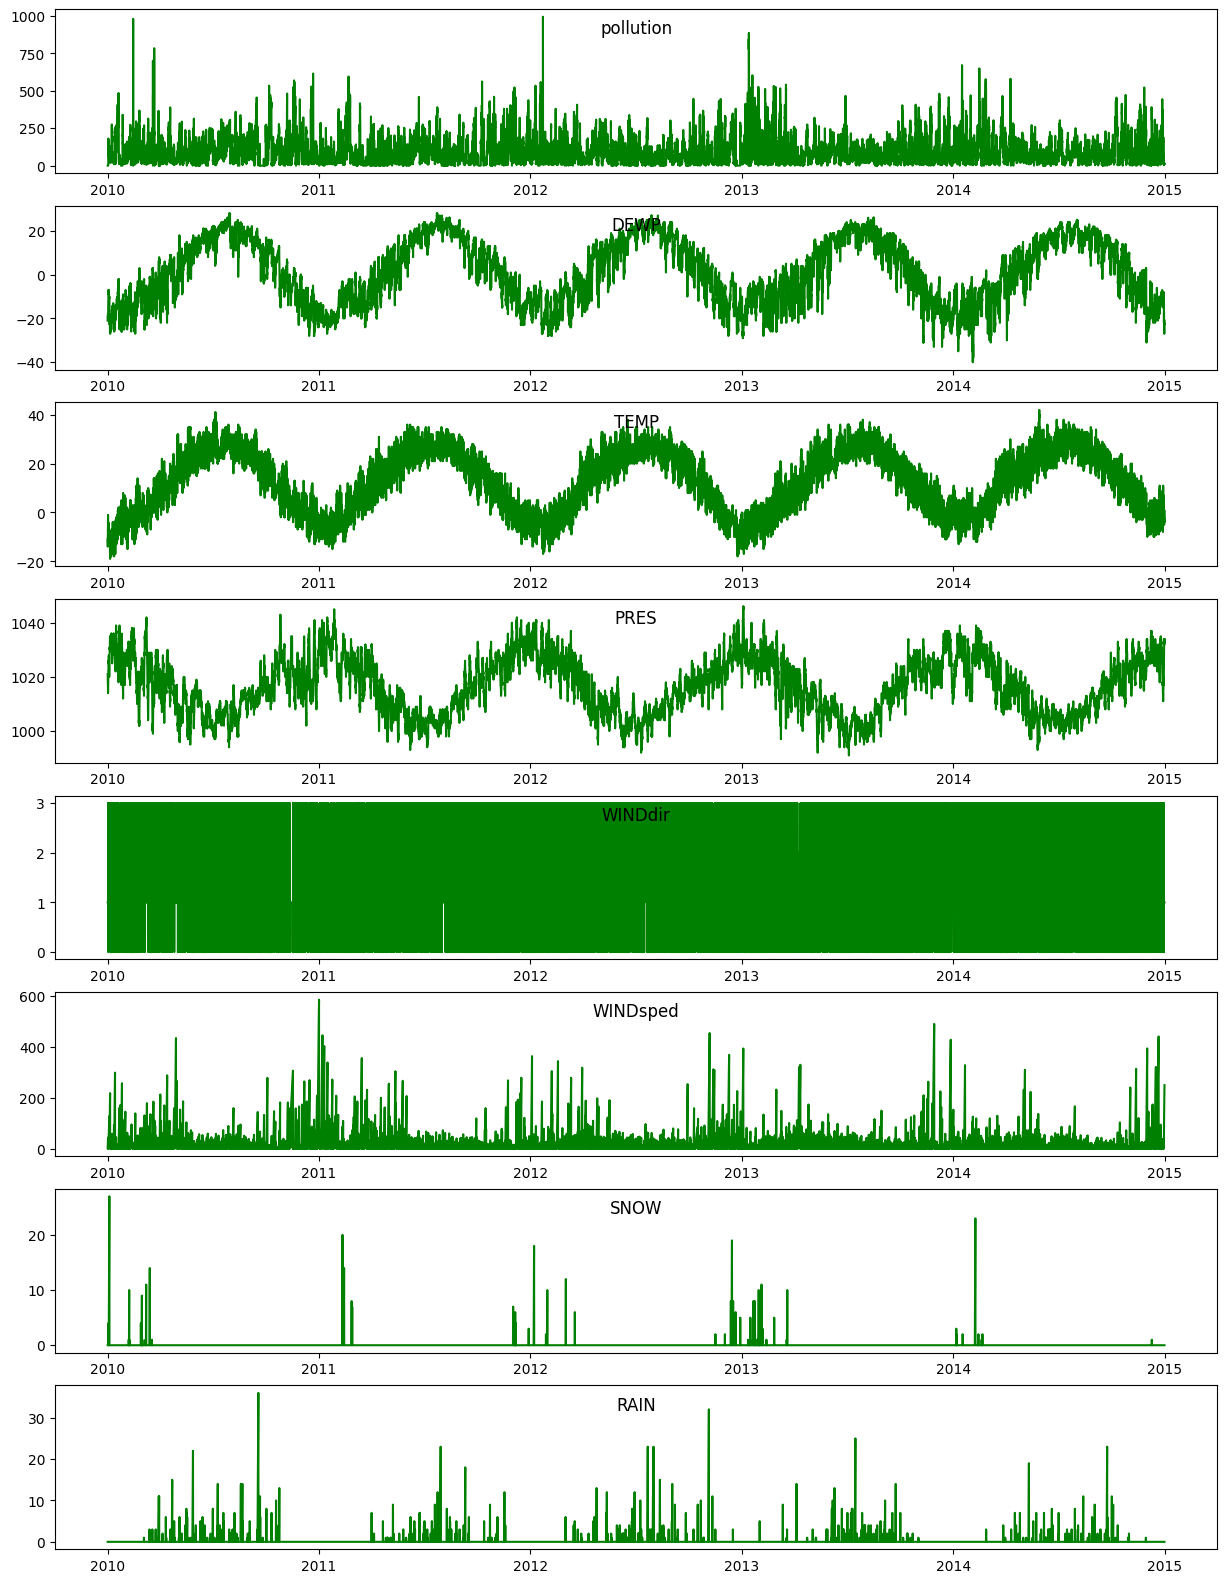

In [11]:
plt.figure(figsize=(15,20))
list_vars = data.columns #("pollution",	"DEWP",	"TEMP",	"PRES",	"WINDsped",	"SNOW",	"RAIN")
for i, var in enumerate(list_vars):
  plt.subplot(data.shape[1], 1, i+1)
  plt.plot(data[var], color='green')
  plt.title(var,y=0.8)

<Axes: >

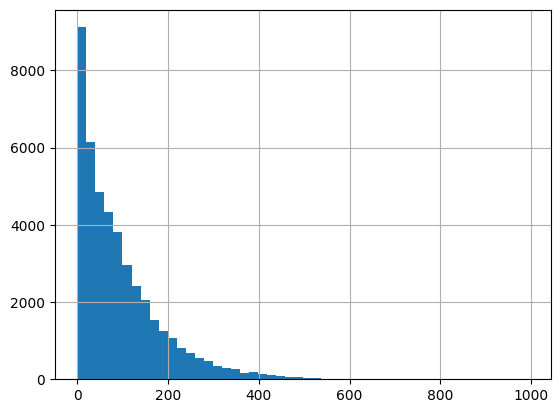

In [12]:
data.pollution.hist(bins=50)

The Autocorrelation plot for the data is:


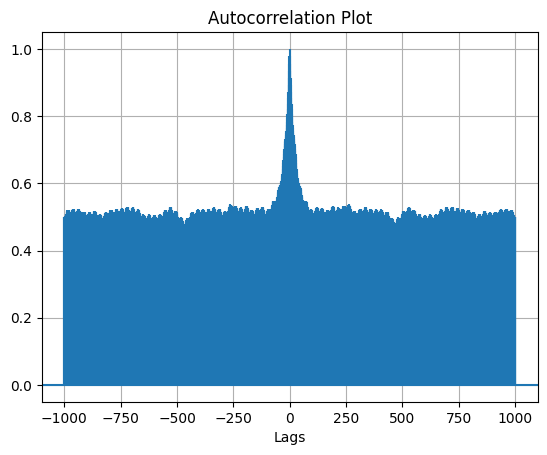

In [13]:
dt=data["pollution"]
pl.title("Autocorrelation Plot")

# Providing x-axis name.
pl.xlabel("Lags")

# Plotting the Autocorrelation plot.
pl.acorr(dt, maxlags = 1000)

# Displaying the plot.
print("The Autocorrelation plot for the data is:")
pl.grid(True)

pl.show()

## Time serie forecasting as supervised learning problem (Regression setting)
* predict the pollution at the next hour (t) given the pollution and weather conditions at the prior time step

<font color='red'>
EXERCICE: Replace the <FILL_IN> with the correct codes to complete the code
 </font>

#### Prepare the pollution dataset for LSTM algorithm

In [14]:
def history_and_horizon_sequencing(df, n_history, n_horizon, target=None):
  # History: look-back sequences (t-n, ... t-1)
  stack_history = []
  for i in range(n_history,0,-1):
    df_i = df.shift(i) # Rows will shift forwardly by i steps
    df_i.columns = [f'{col}_t-{i}' for col in df_i.columns]
    stack_history =  stack_history + [df_i]
  # target dataframe
  if target is None: df_target = df
  else: df_target = df[target].to_frame()
  # Horizon: step-ahead sequences (t+1, ... t+n)
  stack_horizon = []
  for j in range(n_horizon,0,-1):
    df_j = df_target.shift(j)
    df_j.columns = [f'{col}_t+{j}' for col in df_j.columns]
    stack_horizon = [df_j] + stack_horizon
  # Present: t
  df_t = df.copy()
  df_t.columns = [f'{col}_t' for col in df_t.columns]
  # return the concatenated data frame: past+present+future
  return pd.concat(stack_history+[df_t]+stack_horizon, axis=1)

In [ ]:
# ind = pd.date_range('01 / 01 / 2000', periods = 5, freq ='12H')

# # Creating a dataframe with 4 columns
# # using "ind" as the index for our dataframe
# df = pd.DataFrame({"A":[1, 2, 3, 4, 5],
#                    "B":[10, 20, 30, 40, 50],
#                    "C":[11, 22, 33, 44, 55],
#                    "D":[12, 24, 51, 36, 2]},
#                     index = ind)

# # Print the dataframe
# df

In [15]:
data_Xy = history_and_horizon_sequencing(data, 4, 1, target='pollution')
print(data_Xy.shape)
data_Xy.dropna(inplace=True)
print(data_Xy.shape)
data_Xy.head()

(43824, 41)
(43820, 41)


,pollution_t-4,DEWP_t-4,TEMP_t-4,PRES_t-4,WINDdir_t-4,WINDsped_t-4,SNOW_t-4,RAIN_t-4,pollution_t-3,DEWP_t-3,...,RAIN_t-1,pollution_t,DEWP_t,TEMP_t,PRES_t,WINDdir_t,WINDsped_t,SNOW_t,RAIN_t,pollution_t+1
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 04:00:00,0.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0,0.0,-21.0,...,0.0,0.0,-20,-12.0,1018.0,1,12.97,0,0,0.0
2010-01-01 05:00:00,0.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,0.0,-21.0,...,0.0,0.0,-19,-10.0,1017.0,1,16.10,0,0,0.0
2010-01-01 06:00:00,0.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,0.0,-21.0,...,0.0,0.0,-19,-9.0,1017.0,1,19.23,0,0,0.0
2010-01-01 07:00:00,0.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,0.0,-20.0,...,0.0,0.0,-19,-9.0,1017.0,1,21.02,0,0,0.0
2010-01-01 08:00:00,0.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,0.0,-19.0,...,0.0,0.0,-19,-9.0,1017.0,1,24.15,0,0,0.0


In [ ]:
ls=[1,2,4,5,8]
ls[-1]

8

#### Baseline v0: persistance modeling
Use observation from the present time step (t) to predict the observation at the next time step (t+1).   

In [ ]:
def baseline_persistance(serie_t):
  # forecast: predict t+1 with value of t
  # forecast: predict t+1 with value of t
  X, y = serie_t[:-1], serie_t[1:]
  return X,y

def compute_performance(test, forecast,label_test,label_forecast, start_t=400, end_t=500):
  rmse=np.sqrt(mean_squared_error(test,forecast)) # Compute root mean squared error between test and forecast
  print('RMSE: %.3f' % rmse)
  plt.figure(figsize=(15,5))
  plt.plot(test[start_t:end_t], color='b',label=label_test)
  plt.plot(forecast[start_t:end_t], color='r',label=label_forecast)
  plt.legend()
  plt.savefig('{}.png'.format(label_forecast))
  files.download('{}.png'.format(label_forecast))
  plt.show()

RMSE: 0.000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

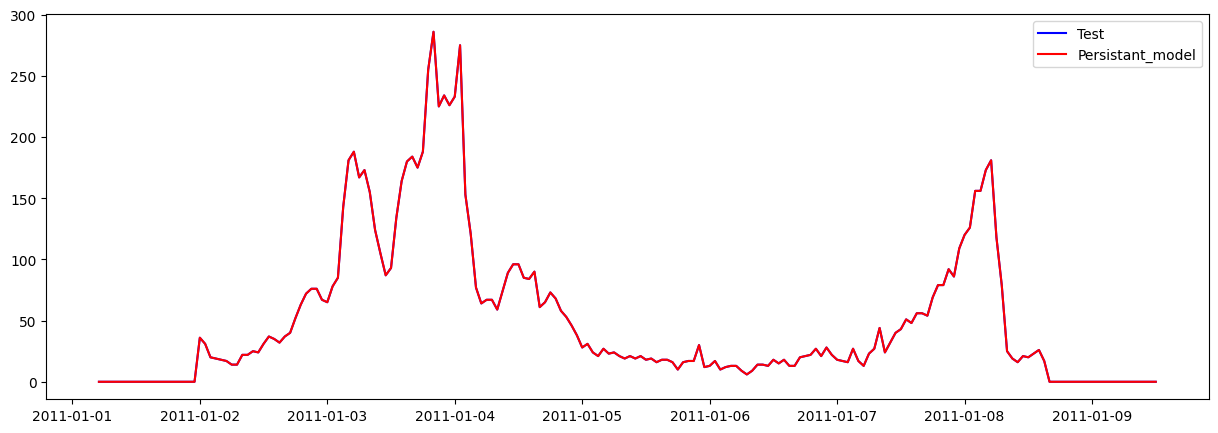

In [ ]:
test_y, persistance_yhat = data_Xy['pollution_t'][1:], baseline_persistance(data_Xy['pollution_t'])[1]
compute_performance(test_y, persistance_yhat,"Test","Persistant_model", start_t=365*24, end_t=365*24+200,)

In [ ]:
# data_Xy['pollution_t'][1:].shape
baseline_persistance(data_Xy['pollution_t'])[1].shape

(43819,)

#### LSTM model

#### Split data into train and test sets
Build train and test dataset for training the model on the first one(1) year and prediction of the four(4) lastest years

In [ ]:
def split_train_test(values, n_train_hours = 365*24):
  # Split the data into train (use values before n_train_hours) and test sets (use values after n_train_hours)
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features] required for LSTM
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
  return train_X, train_y, test_X, test_y

In [ ]:
train_X, train_y, test_X, test_y = split_train_test(data_Xy.values)

(8760, 1, 40) (8760,) (35060, 1, 40) (35060,)


#### Build an LSTM model

In [ ]:
def build_lstm_model(input_shape, nb_neurons ):
  '''
  train and test: input shape 1 time step with 8 features
  LSTM:
   * nb_neurons: hidden state
   * 1 neuron for output layer for prediction.
  '''
  model = Sequential()
  # Add an LSTM layer with nb_neurons and input_shape=input_shape
  model.add(LSTM(units=nb_neurons, input_shape=input_shape, return_sequences = True))
  model.add(LSTM(units=32, input_shape=input_shape,activation="relu"))

  # Add a Dense layer with one output neuron
  model.add(Dense(units=1))

  # model compile
  model.compile(loss='mse', optimizer='adam')
  # Train the model
  return model

def train_model(model, train_X, train_y, test_X, test_y, epochs=500, batch_size=72, verbose=0):
  '''
  Generic function to train model
  '''
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=verbose, shuffle=False)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

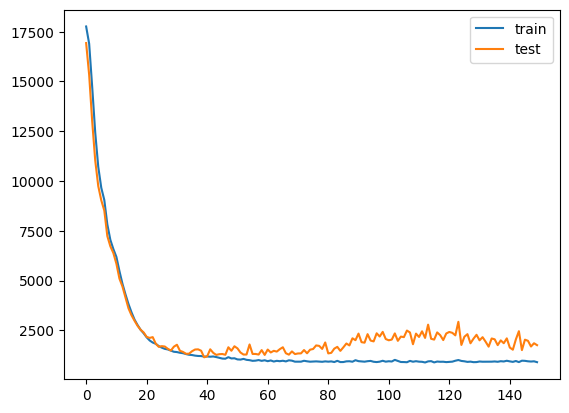

In [ ]:
# Build and train the model
input_shape=(train_X.shape[1], train_X.shape[2])
# Build and train the model using the build_lstm_model (new instance lstm_model)
lstm_model = build_lstm_model(input_shape, nb_neurons = 13)
# Train the new model using train_model method with params lstm_model, train_X, train_y, test_X, test_y, epochs=100, batch_size=72, verbose=0
train_model(lstm_model, train_X, train_y, test_X, test_y, epochs = 150, batch_size = 72, verbose = 0)

In [ ]:
# early_stopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,mode='min')
# model.compile(loss=tf.losses.MeanSquaredError(),optimizer='adam',metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])
# history=model.fit(train_generator,epochs=160,shuffle=False, validation_data=val_generator,callbacks=[early_stopping])

1096/1096 [==============================] - 3s 2ms/step
RMSE: 41.976


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

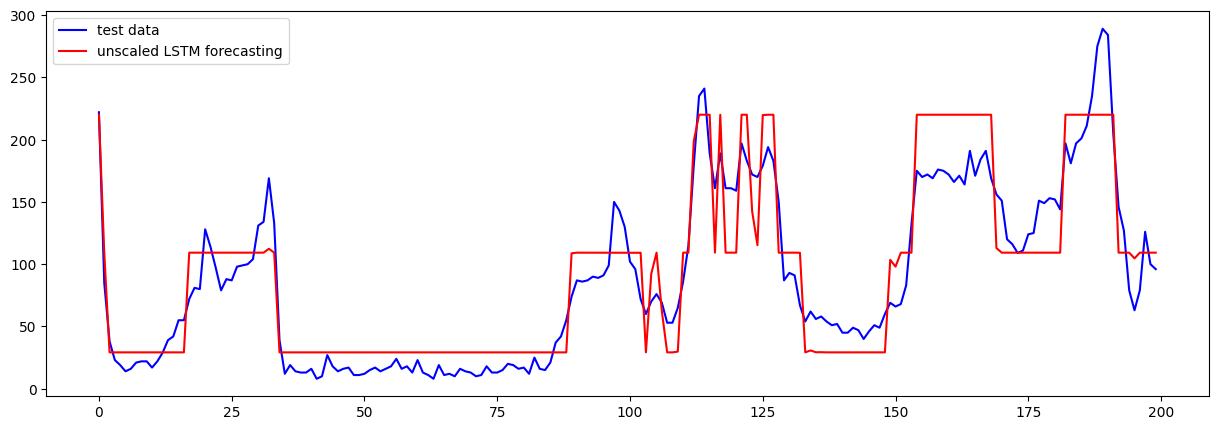

In [ ]:
# make the prediction of test_X (store in lstm_yhat)
lstm_yhat = lstm_model.predict(test_X)
# compute performance
compute_performance(test_y, lstm_yhat,"test data","unscaled LSTM forecasting", start_t=365*24, end_t=365*24+200)

#### LSTM trained with scaling data

In [ ]:
# Normalize features
values = data_Xy.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
# Create train/tests datasets from scaled_data
scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values)

(8760, 1, 40) (8760,) (35060, 1, 40) (35060,)


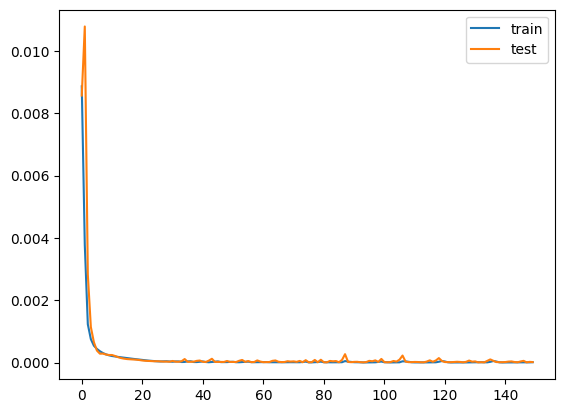

In [ ]:
# Build and train the model using the build_lstm_model (new instance name lstm_model_scaled)
lstm_model_scaled = build_lstm_model(input_shape, nb_neurons = 13)
# Train the new model using train_model method as previousely using the new scaled data
train_model(lstm_model_scaled, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs = 150, batch_size = 64, verbose = 0)

1096/1096 [==============================] - 4s 3ms/step
RMSE: 4.179


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

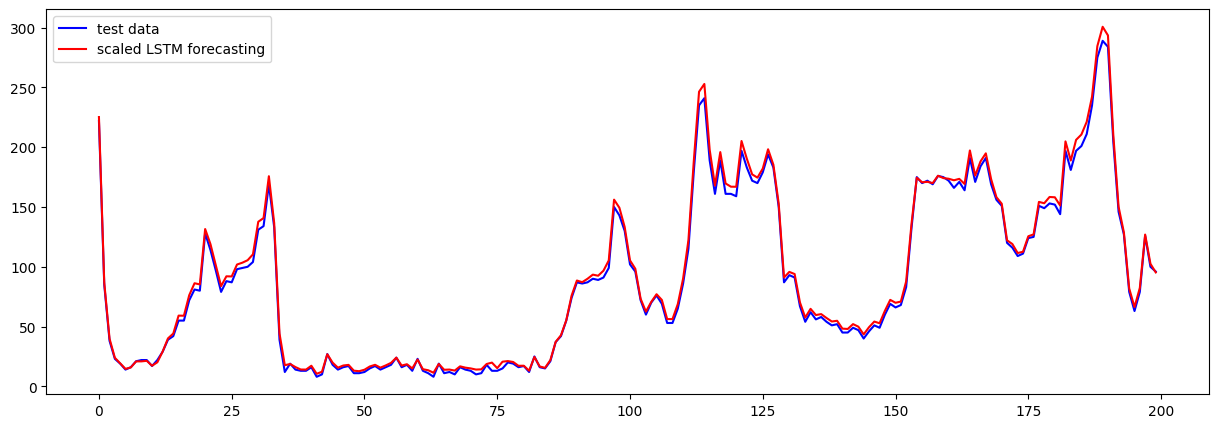

In [ ]:
# invert scaling for forecast
def invert_scaling(scaled_X, scaled_yhat):
  scaled_tX = scaled_test_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = concatenate((scaled_tX, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]

# make a prediction
lstm_scaled_yhat = lstm_model_scaled.predict(scaled_test_X)
# compute performance
inv_yhat = invert_scaling(scaled_test_X, lstm_scaled_yhat)
compute_performance(test_y, inv_yhat,"test data","scaled LSTM forecasting", start_t=365*24, end_t=365*24+200)

In [ ]:
# inv_yhat.shape, test_y.shape
365*24, 365*24+200

(8760, 8960)

#### Build an Stacked LSTM model

Stacked LSTM model refers to stacking multiple hidden LSTM layers one on top of another.

In [ ]:
#Build a LSTM with autoencoder architecture
def build_stacked_lstm_model(input_shape, nb_neurons ):
  model = Sequential()
  # Add an LSTM layer with nb_neurons and input_shape=input_shape and return_sequences=True (required sequences needed for next LSTM Bloc)
  model.add(LSTM(units=nb_neurons, input_shape=input_shape, return_sequences = True))
  model.add(LSTM(units=64, input_shape=input_shape, return_sequences = True))
  # model.add(LSTM(units=24, input_shape=input_shape, return_sequences = True))
  model.add(LSTM(units=6, input_shape=input_shape, activation='relu'))
  # Add a Dense layer with one output neuron
  model.add(Dense(units=1))
  model.compile(loss='mse', optimizer='adam')
  return model

  # Train the model
  # Train the model
   # model.add(LSTM(units=18, input_shape=input_shape, return_sequences = True))
  # Add an additional LSTM layer with nb_neurons and 'relu' activation function
  # model.add(LSTM(units=12, input_shape=input_shape, return_sequences = True))
  # model.add(LSTM(units=2, input_shape=input_shape, return_sequences = True))
  # model.add(LSTM(units=12, input_shape=input_shape, return_sequences = True))

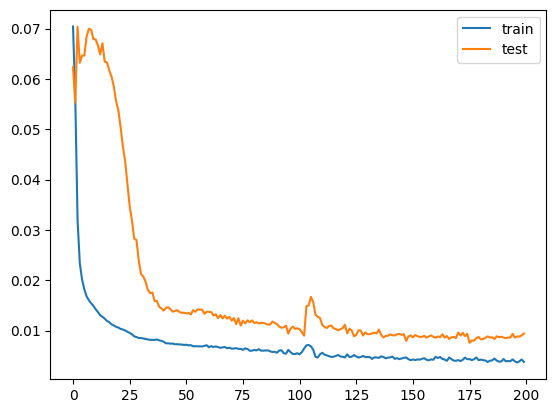

In [ ]:
input_shape = (train_X.shape[1], train_X.shape[2])
# Build the new stacked_lstm_model
def invert_scaling(scaled_X, scaled_yhat):
  scaled_tX = scaled_test_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = concatenate((scaled_tX, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]
stacked_lstm_model = build_stacked_lstm_model(input_shape, nb_neurons = 17)
# Train the model stacked_lstm_model on scaled data
train_model(stacked_lstm_model, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs = 200, batch_size = 128, verbose = 0)

1096/1096 [==============================] - 4s 3ms/step
RMSE: 15.056


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

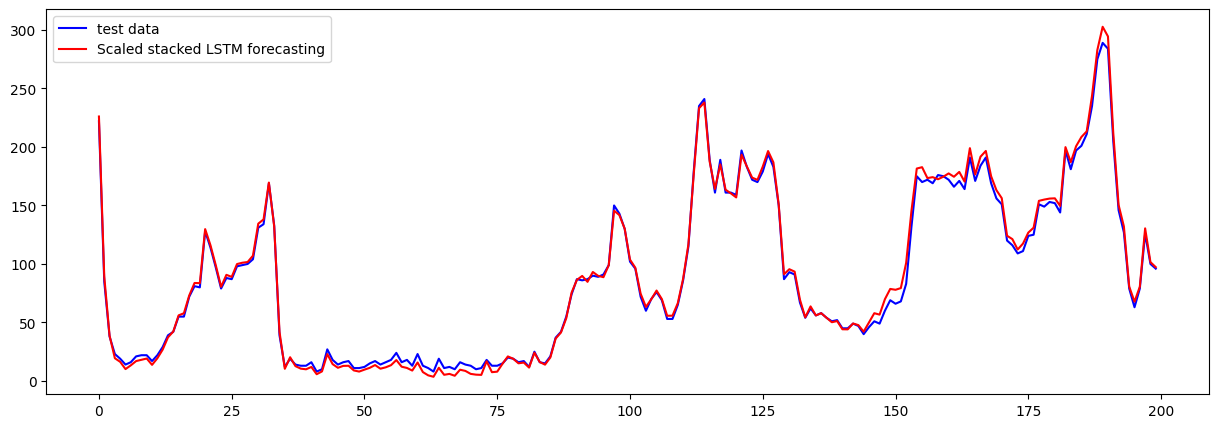

In [ ]:
# make a prediction with stacked_lstm_model using scaled_test_X (output in variable scaled_stacked_lstm_yhat)
scaled_stacked_lstm_yhat = stacked_lstm_model.predict(scaled_test_X)
def invert_scaling(scaled_X, scaled_yhat):
  scaled_tX = scaled_test_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = concatenate((scaled_tX, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]
# compute performance
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_lstm_yhat )
compute_performance(test_y, inv_yhat,"test data","Scaled stacked LSTM forecasting", start_t=365*24, end_t=365*24+200)

# # compute performance
# inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_lstm_yhat)
# compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)

# OTHER METHOD

#Bidirectional LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Bidirectional,LSTM
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers

In [ ]:
# from pickle import TRUE
def Bi_LSTM(input_shape, nb_neurons ):
  model= keras.Sequential()
  model.add(Bidirectional(LSTM(nb_neurons, return_sequences=True), input_shape=input_shape))
  model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
  model.add(Bidirectional(LSTM(6, return_sequences=False,activation="relu"), input_shape=input_shape))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  return model

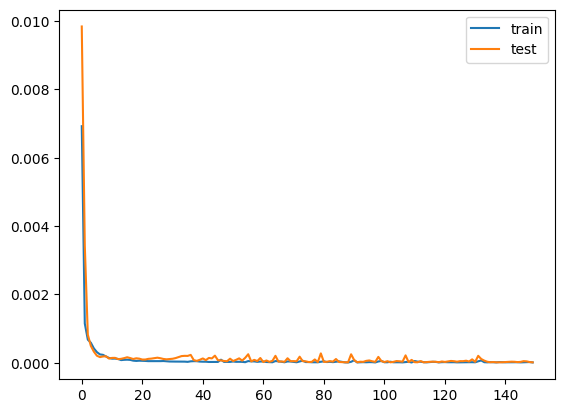

In [ ]:
# Build and train the model using the build_lstm_model (new instance lstm_model)
Bilstm_model = Bi_LSTM(input_shape, nb_neurons = 64)
# Train the new model using train_model method with params lstm_model, train_X, train_y, test_X, test_y, epochs=100, batch_size=72, verbose=0
train_model(Bilstm_model, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs = 150, batch_size = 64, verbose = 0)

1096/1096 [==============================] - 7s 5ms/step
RMSE: 3.890


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

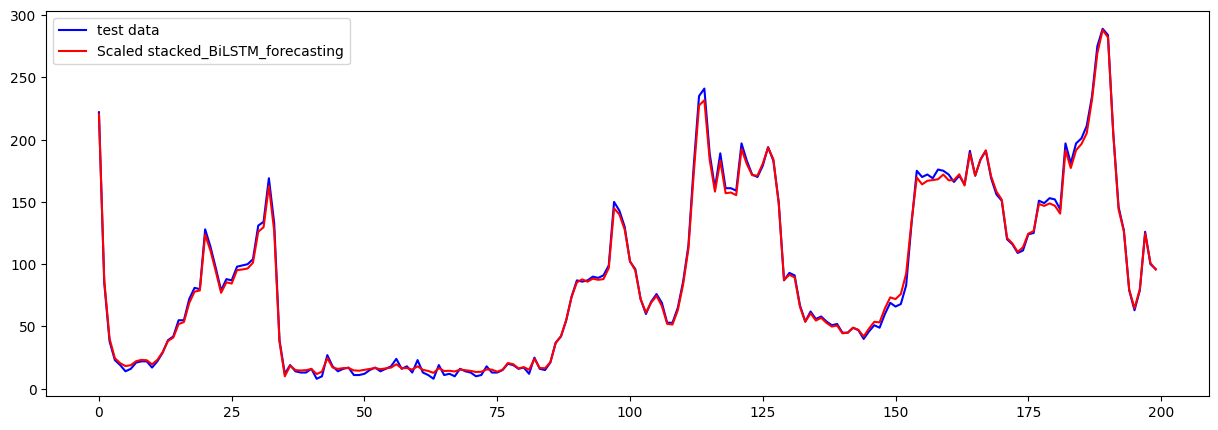

In [ ]:
scaled_stacked_Bilstm_yhat = Bilstm_model .predict(scaled_test_X)

# compute performance
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_Bilstm_yhat)
compute_performance(test_y, inv_yhat,"test data","Scaled stacked_BiLSTM_forecasting", start_t=365*24, end_t=365*24+200)

## Assignment: Work to improve the performance - try different strategies:
* Hyperparameters tuning
* Test other models:
 - Eg. 1D-ConvNet LSTM, Bidirectional